In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2021/train.csv
/kaggle/input/tabular-playground-series-aug-2021/test.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
import warnings
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import explained_variance_score
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/test.csv')

In [4]:
train.head(3)

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,...,-42.43990,26.85400,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,...,-184.13200,7.90137,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,...,7.43721,37.21810,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6


In [5]:
test.head(3)

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.0436,0.942256,29.8980,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.01057,1.94664,0.529470,1.386950,8.78767
1,250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.8050,0.807194,38.4219,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.44057,1.90309,0.248534,0.863881,11.79390
2,250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.2400,-0.003300,37.9400,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.83860,1.83385,0.931796,2.336870,9.05400


In [6]:
print('training set details:')
print('-' * 21)
print('shape:')
print()
print(train.shape)
print('*' * 50)
print('null columns:')
print()
print(train.isnull().sum())
print('*' * 50)
print('total nulls:')
print()
print(sum(train.isnull().sum()))
print('*' * 50)
print('info:')
print()
print(train.info())

training set details:
---------------------
shape:

(250000, 102)
**************************************************
null columns:

id      0
f0      0
f1      0
f2      0
f3      0
       ..
f96     0
f97     0
f98     0
f99     0
loss    0
Length: 102, dtype: int64
**************************************************
total nulls:

0
**************************************************
info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 102 entries, id to loss
dtypes: float64(95), int64(7)
memory usage: 194.5 MB
None


In [7]:
print('testing set details:')
print('-' * 20)
print('shape:')
print()
print(test.shape)
print('*' * 50)
print('null columns:')
print()
print(test.isnull().sum())
print('*' * 50)
print('total nulls:')
print()
print(sum(test.isnull().sum()))
print('*' * 50)
print('info:')
print()
print(test.info())

testing set details:
--------------------
shape:

(150000, 101)
**************************************************
null columns:

id     0
f0     0
f1     0
f2     0
f3     0
      ..
f95    0
f96    0
f97    0
f98    0
f99    0
Length: 101, dtype: int64
**************************************************
total nulls:

0
**************************************************
info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 101 entries, id to f99
dtypes: float64(95), int64(6)
memory usage: 115.6 MB
None


In [8]:
train.describe()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,124999.500000,0.511213,51.378476,0.107155,0.050010,3595.133426,8.205953,164.508753,0.375533,16.669745,...,4856.812768,22.579100,2.030554,0.079692,1.555097,2.417556,0.537484,1.576900,8.048805,6.813920
std,72168.927986,0.307884,42.396636,1.322200,0.792368,6072.401061,5.475723,183.335563,0.813597,99.758709,...,8501.609009,14.849390,0.900211,0.587780,9.253785,0.892563,0.226589,0.646306,5.647368,7.940179
min,0.000000,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,...,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.005249,-0.646967,-0.842397,0.000000
25%,62499.750000,0.251287,18.000000,-0.611172,-0.719418,163.864750,4.110127,27.894900,-0.026245,-17.392025,...,73.203100,11.525450,1.471650,-0.408975,-4.004925,1.906718,0.359646,1.215810,3.732800,1.000000
50%,124999.500000,0.514962,41.000000,0.253815,0.004099,943.000500,7.472445,91.005250,0.619862,8.714945,...,1060.025000,19.993200,1.660830,0.215710,0.759942,2.340430,0.531348,1.451285,7.182205,4.000000
75%,187499.250000,0.777323,75.000000,0.759249,0.765456,4115.355000,11.030950,240.843750,0.933855,55.407625,...,5572.982500,32.271625,2.320085,0.503134,6.202502,2.910020,0.709807,1.901632,10.998550,10.000000
max,249999.000000,1.072070,273.000000,9.768590,1.680190,37847.500000,35.078000,947.143000,4.010380,465.956000,...,54334.600000,79.912400,5.403020,1.944190,42.890400,5.576040,1.105400,4.492620,34.019200,42.000000


In [9]:
train['loss'].describe().to_frame()

,loss
count,250000.000000
mean,6.813920
std,7.940179
min,0.000000
25%,1.000000
50%,4.000000
75%,10.000000
max,42.000000


In [10]:
test.describe()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,324999.500000,0.513137,51.612380,0.108166,0.047793,3567.849290,8.189529,163.303236,0.379849,16.626872,...,0.582965,4858.089360,22.590537,2.028026,0.079295,1.565588,2.422223,0.537009,1.575402,8.045628
std,43301.414527,0.307512,42.662212,1.338636,0.790894,6045.626929,5.443633,181.799298,0.812515,99.813298,...,0.445033,8497.126809,14.838069,0.898257,0.590101,9.268188,0.894294,0.226024,0.645402,5.642812
min,250000.000000,-0.064172,-17.000000,-7.952920,-1.491030,-7801.580000,-3.097580,-39.020100,-4.062280,-496.326000,...,-0.466885,-12183.200000,-4.134800,0.120638,-2.013430,-24.337800,-1.056300,0.010615,-0.673333,-0.762355
25%,287499.750000,0.254897,18.000000,-0.615063,-0.718730,161.797000,4.129198,27.774750,-0.024041,-17.780300,...,0.282301,73.567275,11.585500,1.470310,-0.408236,-4.015442,1.910507,0.359924,1.216300,3.719902
50%,324999.500000,0.516855,41.000000,0.253162,0.003786,935.088500,7.467945,90.090350,0.622288,8.433805,...,0.483258,1054.480000,19.939150,1.660235,0.215228,0.811492,2.341185,0.530720,1.449735,7.191640
75%,362499.250000,0.778300,76.000000,0.759430,0.761793,4076.672500,11.016600,239.953000,0.936772,55.053075,...,0.770184,5613.215000,32.208850,2.308523,0.502962,6.218857,2.918890,0.708449,1.895473,11.018700
max,399999.000000,1.072210,270.000000,9.931070,1.670420,38434.400000,34.533000,943.297000,4.183330,466.535000,...,3.347080,54417.900000,80.209000,5.421360,1.920450,42.504100,5.583770,1.102790,4.472940,33.686300


<AxesSubplot:xlabel='loss', ylabel='count'>

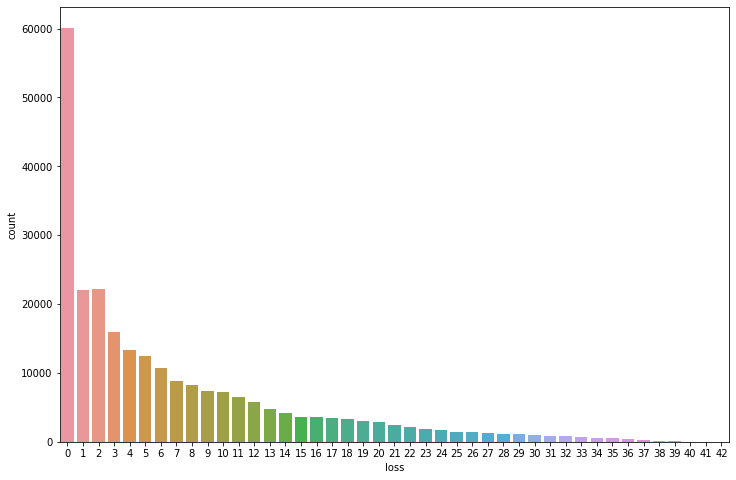

In [11]:
plt.subplots(figsize = (12,8))
sns.countplot(train['loss'])

In [12]:
from sklearn.feature_selection import VarianceThreshold as vt
features = train.iloc[:,1:101]
target = train['loss']
v = vt(threshold = 0.8)
v = v.fit(features, target)

cols = v.get_support(indices = True)
cols.shape

(63,)

In [13]:
x_train = train.iloc[:, 1:101]
x_test = test.drop('id', axis = 1)

In [14]:
mm = MinMaxScaler().fit(x_train)
x_train_mm = mm.transform(x_train)
x_test_mm = mm.transform(x_test)

In [15]:
xtrain_data = pd.DataFrame(x_train_mm)
xtest_data = pd.DataFrame(x_test_mm)
xtrain_data['loss'] = train['loss']

In [16]:
print('xtrain_data shape:')
print()
print(xtrain_data.shape)
print('*' * 50)
print('xtest_data shape:')
print()
print(xtest_data.shape)

xtrain_data shape:

(250000, 101)
**************************************************
xtest_data shape:

(150000, 100)


In [17]:
X_train1 = x_train.copy()
X_test1 = x_test.copy()
num_cols = x_train.columns
for i in num_cols:
    scale = StandardScaler().fit(X_train1[[i]])
    X_train1[i] = scale.transform(X_train1[[i]])
    X_test1[i] = scale.transform(X_test1[[i]])

X_train1["loss"] = train["loss"]

In [18]:

if "Set" not in X_train1.columns:
    X_train1["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(X_train1.shape[0],))

train_indices = X_train1[X_train1.Set=="train"].index
valid_indices = X_train1[X_train1.Set=="valid"].index

In [19]:
unused_feature = ['Set']
target = 'loss'
feature = [ col for col in X_train1.columns if col not in unused_feature+[target]] 

In [20]:
#train_data
X_train = X_train1[feature].values[train_indices]
y_train = X_train1[target].values[train_indices].reshape(-1, 1)
#valid data 
X_valid = X_train1[feature].values[valid_indices]
y_valid = X_train1[target].values[valid_indices].reshape(-1, 1)

In [21]:
!pip install torchvision
import torch

In [22]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
max_epochs = 1000
Bs = 2048 
clf = TabNetRegressor(  verbose = 10 ,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax'
                           )

Device used : cpu


In [23]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle','rmse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=Bs, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 65.83873| train_rmsle: 1.50756 | train_rmse: 7.94116 | valid_rmsle: 1.49581 | valid_rmse: 7.96146 |  0:00:40s
epoch 10 | loss: 62.64195| train_rmsle: 1.49251 | train_rmse: 7.91057 | valid_rmsle: 1.4816  | valid_rmse: 7.93716 |  0:07:24s
epoch 20 | loss: 62.25094| train_rmsle: 1.50451 | train_rmse: 7.88084 | valid_rmsle: 1.49682 | valid_rmse: 7.91733 |  0:14:09s
epoch 30 | loss: 61.82166| train_rmsle: 1.46031 | train_rmse: 7.8506  | valid_rmsle: 1.46188 | valid_rmse: 7.92075 |  0:20:56s
epoch 40 | loss: 61.27666| train_rmsle: 1.45723 | train_rmse: 7.80631 | valid_rmsle: 1.47575 | valid_rmse: 7.94545 |  0:27:42s
epoch 50 | loss: 60.87091| train_rmsle: 1.44705 | train_rmse: 7.77747 | valid_rmsle: 1.47565 | valid_rmse: 7.95604 |  0:34:23s
epoch 60 | loss: 60.51152| train_rmsle: 1.43632 | train_rmse: 7.75315 | valid_rmsle: 1.47352 | valid_rmse: 7.96965 |  0:40:56s
epoch 70 | loss: 60.26341| train_rmsle: 1.43719 | train_rmse: 7.73027 | valid_rmsle: 1.48234 | valid_rmse: 7.99

In [24]:
print(f"BEST VALID SCORE  : {clf.best_cost}")

BEST VALID SCORE  : 7.916243284313239


In [25]:
test_pred= X_test1.to_numpy()
predictions =  clf.predict(test_pred)

In [26]:
feat_importances = clf.feature_importances_
indices = np.argsort(feat_importances)

In [27]:
sample = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv')
predictions = pd.DataFrame(predictions) # from array to dataframe
sample['loss'] = predictions
sample.to_csv('tabnet_submission.csv',index=False)
sample

,id,loss
0,250000,7.524795
1,250001,5.517050
2,250002,7.030812
3,250003,6.885614
4,250004,7.082747
...,...,...
149995,399995,7.763244
149996,399996,7.350907
149997,399997,6.737794
149998,399998,5.851264
